In [189]:
import pandas as pd
import numpy as np
import os
import json
import yaml
import joblib

In [190]:
# os.makedirs('../data/raw')
# os.makedirs('../data/processed')
# os.makedirs('../src/stages')
# os.makedirs('../metrics')
# os.makedirs('../models')
# os.makedirs('stages')

__Data Load__

In [191]:
# cd Bank-Customer-Churn

In [192]:
with open('params.yaml') as config_:
    config__ = yaml.safe_load(config_)

In [193]:
df_ = pd.read_csv(config__['data']['load_data_path'])
df_.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [194]:
df_.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [195]:
df_['Surname'].nunique()

2932

In [196]:
df_['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

__Featurize__

In [197]:
df_ = df_.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [198]:
df_.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [199]:
geo_map = {
    'France': 0,
    'Germany': 1,
    'Spain': 2
}
gender_map = {
    'Female': 0,
    'Male': 1
}

df_['Geography'] = df_['Geography'].map(geo_map)
df_['Gender'] = df_['Gender'].map(gender_map)

In [201]:
df_.to_csv(config__['data']['_train_path'] + '/features.csv')

__Data_Split__

In [202]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [204]:
df_ = pd.read_csv(config__['data']['_train_path'] + '/features.csv')

X = df_.drop(df_.columns[-1], axis = 1)
y = df_[[df_.columns[-1]]]

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = config__['base']['test_size'],
                                                    random_state = config__['base']['random_state'])

In [ ]:
cols_ = X_train.columns
cols_

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [ ]:
scale_ = MinMaxScaler(feature_range=(0,1))
scale_.fit(X_train)
X_train = scale_.transform(X_train)
X_test = scale_.transform(X_test)

In [ ]:
x_train_df = pd.DataFrame(data = X_train, columns = cols_)
x_test_df = pd.DataFrame(data = X_test, columns = cols_)
y_train_df = pd.DataFrame(data = y_train)
y_test_df = pd.DataFrame(data = y_test)

In [ ]:
x_train_df.to_csv(config__['data']['_train_path'] + '/' + 'xtrain.csv')
x_test_df.to_csv(config__['data']['_train_path'] + '/' + 'xest.csv')
y_train_df.to_csv(config__['data']['_train_path'] + '/' + 'ytrain.csv')
y_test_df.to_csv(config__['data']['_train_path'] + '/' + 'ytest.csv')

__Train__

In [ ]:
xgbc = XGBClassifier(
    n_estimators = config__['train']['params']['_n_estimators'],
    learning_rate = config__['train']['params']['_learning_rate'],
    max_depth = config__['train']['params']['max_depth']
)

X_train = pd.read_csv(config__['data']['x_train_path'])
y_train = pd.read_csv(config__['data']['y_train_path'])

X_train = X_train.values
y_train = y_train['Exited'].values

xgbc.fit(X = X_train,
         y = y_train)

joblib.dump(xgbc, config__['model']['path_'] + '/' + 'model.joblib')

['C:/Users/Ayo Agbaje/Desktop/Bank-Customer-Churn/models/model.joblib']

__Evaluate__

In [ ]:
model = joblib.load(config__['model']['out_path'])

X_test = pd.read_csv(config__['data']['x_test_path'])
y_test = pd.read_csv(config__['data']['y_test_path'])

X_test = X_test.values
y_test = y_test['Exited'].values

preds_ = model.predict(X_test)

roc = roc_auc_score(y_true = y_test, y_score = preds_)
accuracy_score = accuracy_score(y_true = y_test, y_pred = preds_)
precision_score = precision_score(y_true = y_test, y_pred = preds_)

_metric = {
    'roc': roc,
    'accuracy_score': accuracy_score,
    'precision_score': precision_score
}

json.dump(
    obj = _metric,
    fp = open(config__['metric']['path'] + '/' 'metrics.json', 'w'),
    indent = 4,
    sort_keys=True
)

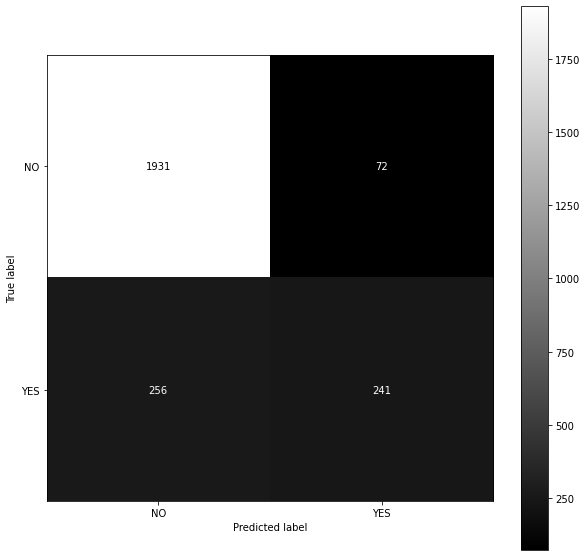

In [206]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = preds_, cmap = 'gist_gray', display_labels = ['NO', 'YES'], ax = ax)
plt.savefig(config__['metric']['path'] + '/confusion_matrix.png')